# Transformer Networks

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
from IPython.display import SVG
from IPython.display import HTML
%matplotlib inline

In [2]:
style = "<style>img{max-height:500px !important;}</style>"
HTML(style) # this resizes SVGS in my site files.

Most of the paper was clear. However, it was difficult to see how it would work across sequences of different length. I don't mean how or why the positional encoding would work - this is intuitive, but rather how they construct the matrices to fit together :).

This notebook focuses on the unique modules the authors present, and how the system fits together. Other *dependencies* of this post can be viewed at the links below. 

* [Byte-Encoding](002.ipynb)
* Layer Normalization
* Residual Connections


## Overview
This work focuses on the task of natural language translation (e.g. english to german or vice versa.)

<div class="alert alert-info">

I modify implementations from the [tensor2tensor](https://github.com/tensorflow/tensor2tensor) library and [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html) post, focusing on my interpretation of the paper. The diagrams are by in large recreations from the original paper. For a complete view and implementation of this system, please visit the mentioned sources above.

</div>

## Encoder Decoder

A encoder-decoder [structure](https://arxiv.org/abs/1409.0473) is used: an input sequence of symbols, $x = { x_1, x_2, \dots, x_n }$, is encoded into a sequence of continuous variables,  $\mathbf{z} = { z_1, z_2, \dots, z_n }$. This is then decoded into a sequence of symbols, $y = { y_1, y_2, \dots, y_n }$. In some cases, $\mathbf{z}$ is a single continuous variable. This generation occurs one at a time - it is [auto-regressive](https://arxiv.org/abs/1308.0850), further consuming the previously generated symbols as additional input when generating the next. Encoder and decoder models usually use a recurrent architecture.

According to Cho. 14, the encoding function $e$ can be any non-linear function, but it is often implemented as an RNN.

\begin{equation} 
h_{<t>} = e(h_{<t-1>}, x_t)
\end{equation}

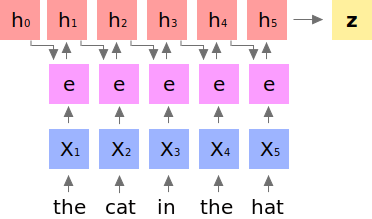

In [3]:
SVG(filename="images/003/encoder.svg")

The input sentence $x$ is encoded into the vector $\mathbf{z}$. Depending on the implemention, we consider the final hidden states as the encoding, or some operation on all the hidden states.

Next, we decode $\mathbf{z}$ into the output predictions $y$. Again, this uses a recurrent function (RNN). 


\begin{align}
h_{<t>} =& d(h_{<t-1>}, y_{<t-1>}, z)\\
y_{<t>} =& g(h_{<t>}, y_{<t-1>}, z)\\
\end{align}

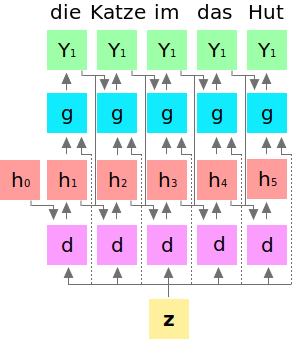

In [4]:
SVG(filename="images/003/decoder.svg")

This structure has some issues.

1. Its sequential and for a given $x$, it cannot be parallelized.
2. Often $\mathbf{z}$ is input into each decoding function, and since $\mathbf{z}$ is O(n) distance to each input symbol, it becomes difficult to learn long range dependencies.
3. The path between an output symbol and its corresponding source symbol depends on the length of $x$.


The transformer network uses a stateless auto-regressive strategy which will decode the encoded (but not summarized) source words and the current output words. This will allow the model to be highly parallelized.

The primary featured used is scaled dot product attention.

## Scaled Dot-Product Attention

The authors describe attention as follows:

> An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors.  The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

In addition to attention, they use a few techniques to regularize their network: layer normalization, residual connections, and dropout.

As noted by the authors, attention maps a query to a combination of given outputs, as determined by the query's corresponding compatibility with the input keys. As the autological "Scaled Dot-Product Attention" method implies, the authors use dot product for their compatibility function. One could use any metric, learned or otherwise. Cosine distance or a layer of MLP can be used.

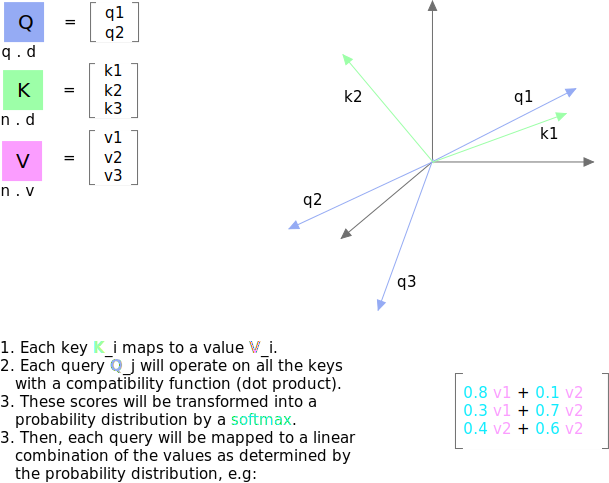

In [5]:
SVG(filename="images/003/attention-example.svg")

As shown in the intuitive example above, the query $q_1$ is most similar to $k_1$, thus it is mapped predimately to the corresponding value $v_1$. Note: these values are examples, not necessarily accurate.

The scaled dot product attention is straight forward.

\begin{equation}
A: Q \times K \times V \to O \\
Q\in \mathbb{R}^{q \times d}, K \in \mathbb{R}^{n \times d}, V \in \mathbb{R}^{n \times v}, O \in \mathbb{R}^{q \times v} \\
A = \text{SOFTMAX}(\frac{QK^{\intercal}}{\sqrt{d}}) V
\end{equation}



The innovative aspect of scaled dot product - beyond the authors' apt framing of the problem as an interaction between queries, keys, and values - is the scaling. The author motivate this scaling by noting that the variance of a dot product scales with the size of the input vectors. Increased variance will result in increased magnitude, "pushing the softmax function into regions where it has extremely small gradients."

<div class="alert alert-info">

Why is the gradient small?

</div>

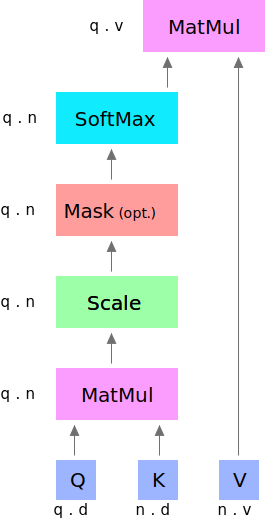

In [6]:
SVG(filename="images/003/scaled-dot-product.svg")

Below is an implementation for the scaled dot product. Each line corresponds to a box in the figure above.

In [7]:
def attention(query, key, value, mask=None):
    "Compute 'Scaled Dot Product Attention'"
    # Compatiblity function (dot product) between the query and keys.
    scores = torch.matmul(query, key.transpose(-2, -1))
    # Scale the scores depending on the size of the inputs.
    scores = scores / math.sqrt(query.size(-1))
    # Optional mask. This is used to zero out values that should not be used by this function.
    if mask is not None:    
        scores = scores.masked_fill(mask == 0, -1e9)
    # Compute probability distribution across the final dimension.
    p_attn = F.softmax(scores, dim = -1)
    # Output linear combinations of values, as determined by the distribution.
    return torch.matmul(p_attn, value), p_attn

### Self Attention
With a single query, self attention will have no effect. This is because the attention mechanism will be a linear combination of the values, and it can only reproduce itself so it serves as an identity function.

In [8]:
def SelfAttention(X):
    Q, K, V = X, X, X
    return attention(Q, K, V)

In [9]:
out, alpha = SelfAttention(torch.FloatTensor([[0.1,0.1,0.8]]))
print(out)
print(alpha)

tensor([[0.1000, 0.1000, 0.8000]])
tensor([[1.]])


When there are multiple queries, the vectors that are most *compatible* will become even more similar as they will be mapped to combinations consisting mostly of the already compatible vectors. 

The remaining vector will also be normalized *different*.

In [10]:
X = torch.FloatTensor([
    [0,0,1],
    [0,0,2],
    [1,0,0]
])
out, alpha = SelfAttention(X)
print(alpha)

tensor([[0.2992, 0.5329, 0.1679],
        [0.2228, 0.7070, 0.0702],
        [0.2645, 0.2645, 0.4711]])


Note that, especially with values greater than 1, a vector can have a greater dot product with other vectors rather than itself. So, similarity is aptly not the correct word to describe this interaction (at least when using a dot product). Thus, the first vector is mapped to a construction consisting mostly of itself and the second vector follows the same trend but more extreme. Lastly, the third vector, less compatible than the others - becomes pseduo-normalized.

In [11]:
print(out)

tensor([[0.1679, 0.0000, 1.3650],
        [0.0702, 0.0000, 1.6368],
        [0.4711, 0.0000, 0.7934]])


## Multi Head Attention


The transformer uses "Multi-Head Attention" as its primary module. It is built up using scaled dot product attention.

Rather than attend raw queries a single time, this method attends *h* linear projections of the input. For each of the *h* heads, the inputs (K,Q,V) are projected linearily with a learned mapping. This is great! Rather than using a single dot product, the multi-headed attention can learn to project vectors and attend them differently. 

<div class="alert alert-info">
Ultimately, the compatiblity function and the projections are all linear - perhaps it would be worth the time to see if non-linear mappings would drastically effect the performance of this method. Does using a feed forward layer here help? hurt?
</div>


\begin{equation}
\text{out} = \texttt{Concat}(\text{head}_0, \dots, \text{head}_h) W^O \\
\text{head}_i = \texttt{Attention}(QW_i^Q, KW_i^K, VW_i^V) \\
Q \in \mathbb{R}^{q \times m}, K \in \mathbb{R}^{n \times m}, V \in \mathbb{R}^{n \times m} \\
W_j^Q, W_j^K, W_j^V \in \mathbb{R}^{m \times d} \\
W^O \in \mathbb{R}^{(h*v)\times m}
\end{equation}

In [12]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

Thus, the multi-headed attention is a function from $R^{q*d}$ to $R^{q*v}$. Furthermore, like the scaled-dot-product attention, it is able to concurrently operate on all the queries in parallel regardless of the size of the sentence.

Additionally, this module is able to support *h* different heads, and still output a fixed-size vector for each query by concat and then matrix multiply to reduce the dimensionality.

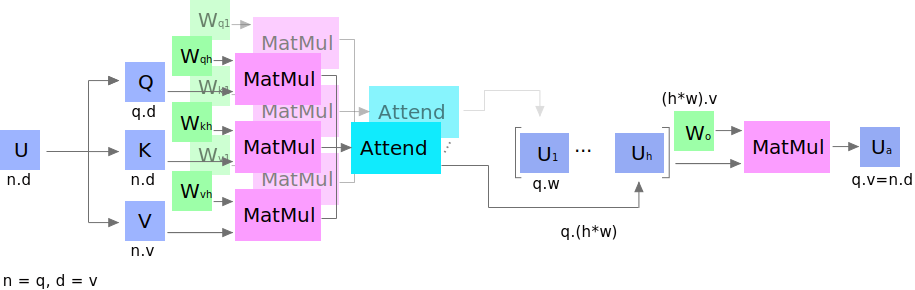

In [13]:
SVG(filename="images/003/multi-head.svg")

## Input Representation

This work used a Byte Pair Encoding scheme. This is a subword tokenization of your vocabulary. This is much more valuable than a UNK symbol. To build this representation, an iterative algorithm can be used to link together the most common segments, starting with character pairs.

## Position-wise Feed-Forward Networks

This two linear transforms with a nonlinear (RELU) operation. The denotation of position-wise remarks on the fact that it is not a convolution, nor does it have any directly spatial functionality.

\begin{equation}
    \text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
\end{equation}

In [14]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model=512, d_ff=2048, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

The remaining features used by the network is residual layers, layer normalization and positional encoding. The structure and features of the model all work to make short paths between inputs and outputs, while also being highly regularized. Layer normalization and residual layers are topics on-to-themselves.

The positional encoding is used to represent the position of the queries in their embeddings. This is important because the attention mechanisms have no notion of order among the queries, and order determines the semantics of a sentence.

The authors use a positional encoding that uses 

\begin{align}
\text{PE}_{(pos,2i)} =& \sin(pos / 10000^{2i/d_{\text{model}}})\\
\text{PE}{(pos,2i+1)} =& \cos(pos / 10000^{2i/d_{\text{model}}})
\end{align}                                                                                                                                                                         
where $pos$ is the position and $i$ is the dimension.  

As the authors describe:

> That is, each dimension of the positional encoding corresponds to a sinusoid.  The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$.  We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.

<div class="alert alert-info">
How can this be represented as a linear function?
</div>

In [15]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2.) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

Again, each dimension corresponds to its location; in the diagram below, each vertical slice of the grapch would be added to the input word embeddings.

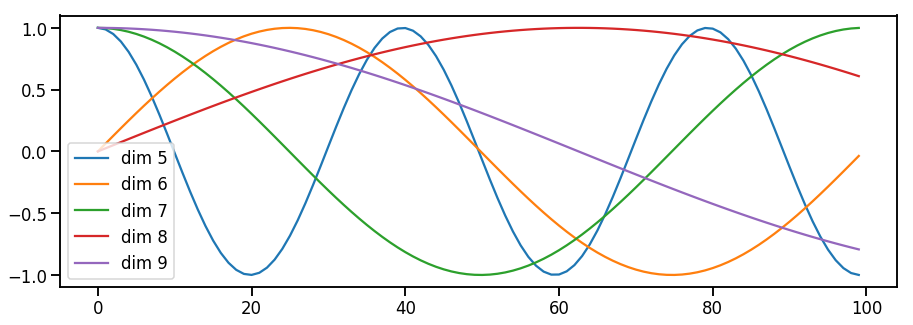

In [16]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0.)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 5:10].data.numpy())
plt.legend(["dim %d"%p for p in [5,6,7,8,9,10]])
None

The authors use dropout to reduce the strength of the signal; the figure below demonstrates its effect.

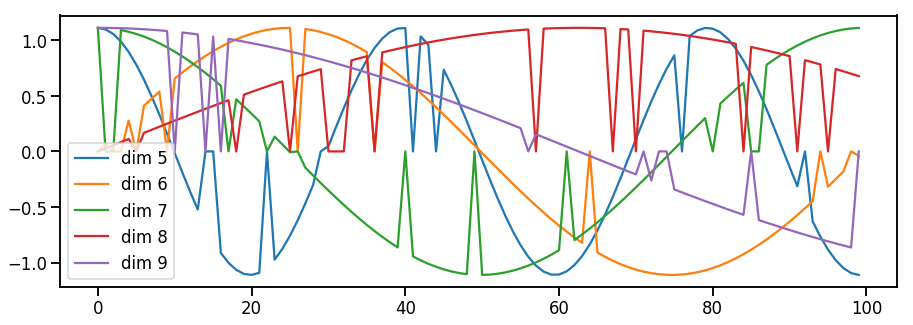

In [17]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0.1)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 5:10].data.numpy())
plt.legend(["dim %d"%p for p in [5,6,7,8,9,10]])
None

## Architecture

Each instance of the transformer will output a probability for the next symbol. As you can see, the encoder and decoder stacks are repeated N times each. In the paper the default was N = 6. The input and ouput of each stack is the of the same dimensionality. 

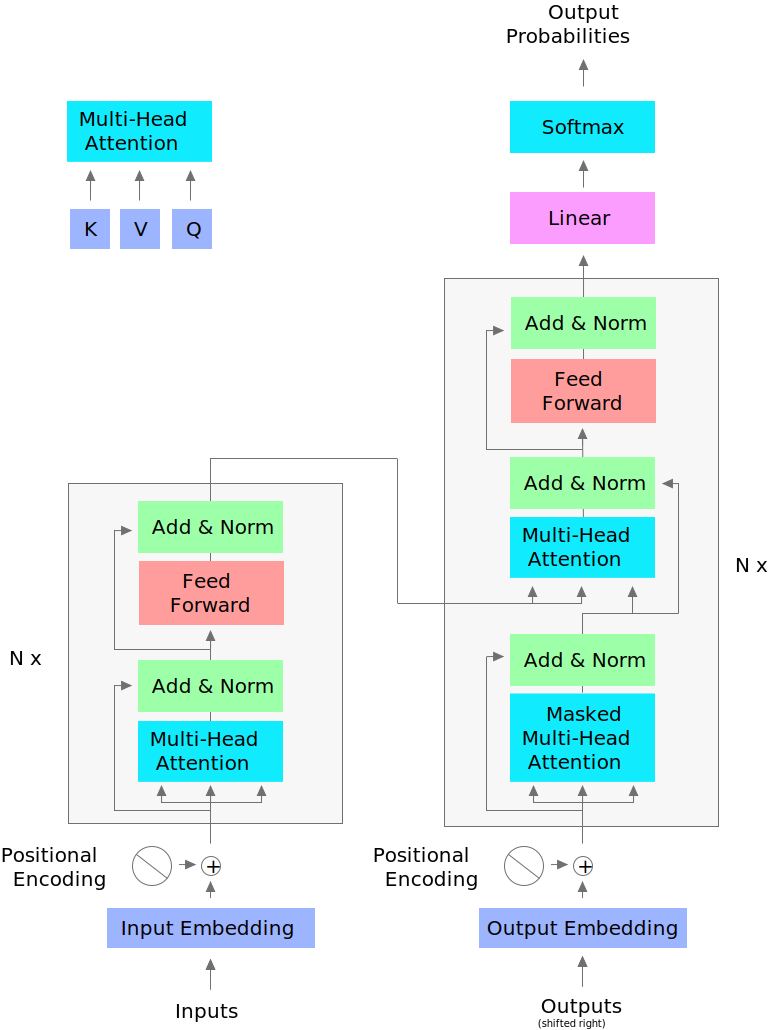

In [18]:
SVG(filename="images/003/architecture.svg")

### Decoding
The linear layer takes an input of $\mathbb{R}^{q \times m}$ and has a weight shape of $\mathbb{R}^{m \times vocab}$, outputing $\mathbb{R}^{q \times vocab}$. During training, the decoding is set so that all subsequent positions are masked out during attention, so that a symbol could never see "into the future". So, the final linear layer will output a probability distribution for each query (each symbol generated so far) starting with the start symbol. When decoding the next symbol will always be the right-most dimension.

When decoding an output sequence, the network is run repeatedly. A greedy approach looks something like this:

In [19]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    # generate a word up to the max length. the system could represent stop symbols to stop early.
    for i in range(max_len-1):
        out = model.decode(
            memory, 
            src_mask,
            Variable(ys),
            Variable(subsequent_mask(ys.size(1)).type_as(src.data)))
        # select the final outputs' result.
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        # concat the most likely word to the result.
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

Using [beam search](004.ipynb) (as the authors did do), a path is selected by maintaining *k* beams - i.e. the best-so-far $k$ options.